<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

## Desafío 4 - Procesamiento del Lenguaje Natural I
##### Docentes: Rodrigo Cárdenas / Nicolás  Vattuone
##### Autora: María Luz Micozzi

## LSTM Bot QA

### 1 - Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import logging
import os
from pathlib import Path
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences, to_categorical, plot_model
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Dense, Flatten, LSTM, Input
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 20.2MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [7]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_words = 10

def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("\'d", " had")
    txt = txt.replace("\'s", " is")
    txt = txt.replace("\'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

count_exceeds = 0
for line in data:
    for i in range(len(line['dialog'])-1):
        # separamos el texto en "preguntas" (chat_in) y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        # Medir por número de palabras
        if len(chat_in.split()) >= max_words or len(chat_out.split()) >= max_words:
            count_exceeds += 1
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

In [8]:
print("Cantidad de intercambios utilizados:", len(input_sentences))
print("Cantidad de intercambios descartados por longitud:", count_exceeds)

Cantidad de intercambios utilizados: 9092
Cantidad de intercambios descartados por longitud: 4420


In [9]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [10]:
# Vocabulario máximo
MAX_VOCAB_SIZE = 8000

In [11]:
# input tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario de entrada:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario de entrada: 2724
Sentencia de entrada más larga: 9


In [12]:
# output tokenizer
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario de salida:", len(word2idx_outputs))

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)

Palabras en el vocabulario de salida: 2731
Sentencia de salida más larga: 10


In [13]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 9092
encoder_input_sequences shape: (9092, 9)
decoder_input_sequences shape: (9092, 10)


In [14]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("decoder_output_sequences shape:", decoder_output_sequences.shape)
print("decoder_targets shape:", decoder_targets.shape)

decoder_output_sequences shape: (9092, 10)
decoder_targets shape: (9092, 10, 2732)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [15]:
# Se descargan los emebeddings de FastText

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

!gunzip cc.en.300.vec.gz

--2025-06-14 18:44:42--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   159MB/s    in 10s     

2025-06-14 18:44:53 (123 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [16]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [17]:
# Se crea la clase para manejar los embeddings de FastText
model_embeddings = FasttextEmbeddings()

In [18]:
# Crear la Embedding matrix de las secuencias

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [19]:
# Dimensión de los embeddings de la secuencia
embedding_matrix.shape

(2724, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [20]:
n_units = 128

# ----- Encoder -----
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding_layer = Embedding(
    input_dim=nb_words,
    output_dim=embed_dim,
    input_length=max_input_len,
    weights=[embedding_matrix],
    trainable=False
)
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.5)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# ----- Decoder -----
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_embedded  = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_embedded , initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer="rmsprop",
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 9, 300)    │    817,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 128)   │    349,696 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │    219,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 2732)  │    352,428 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,870,556 (7.14 MB)

 Trainable params: 1,053,356 (4.02 MB)

 Non-trainable params: 817,200 (3.12 MB)

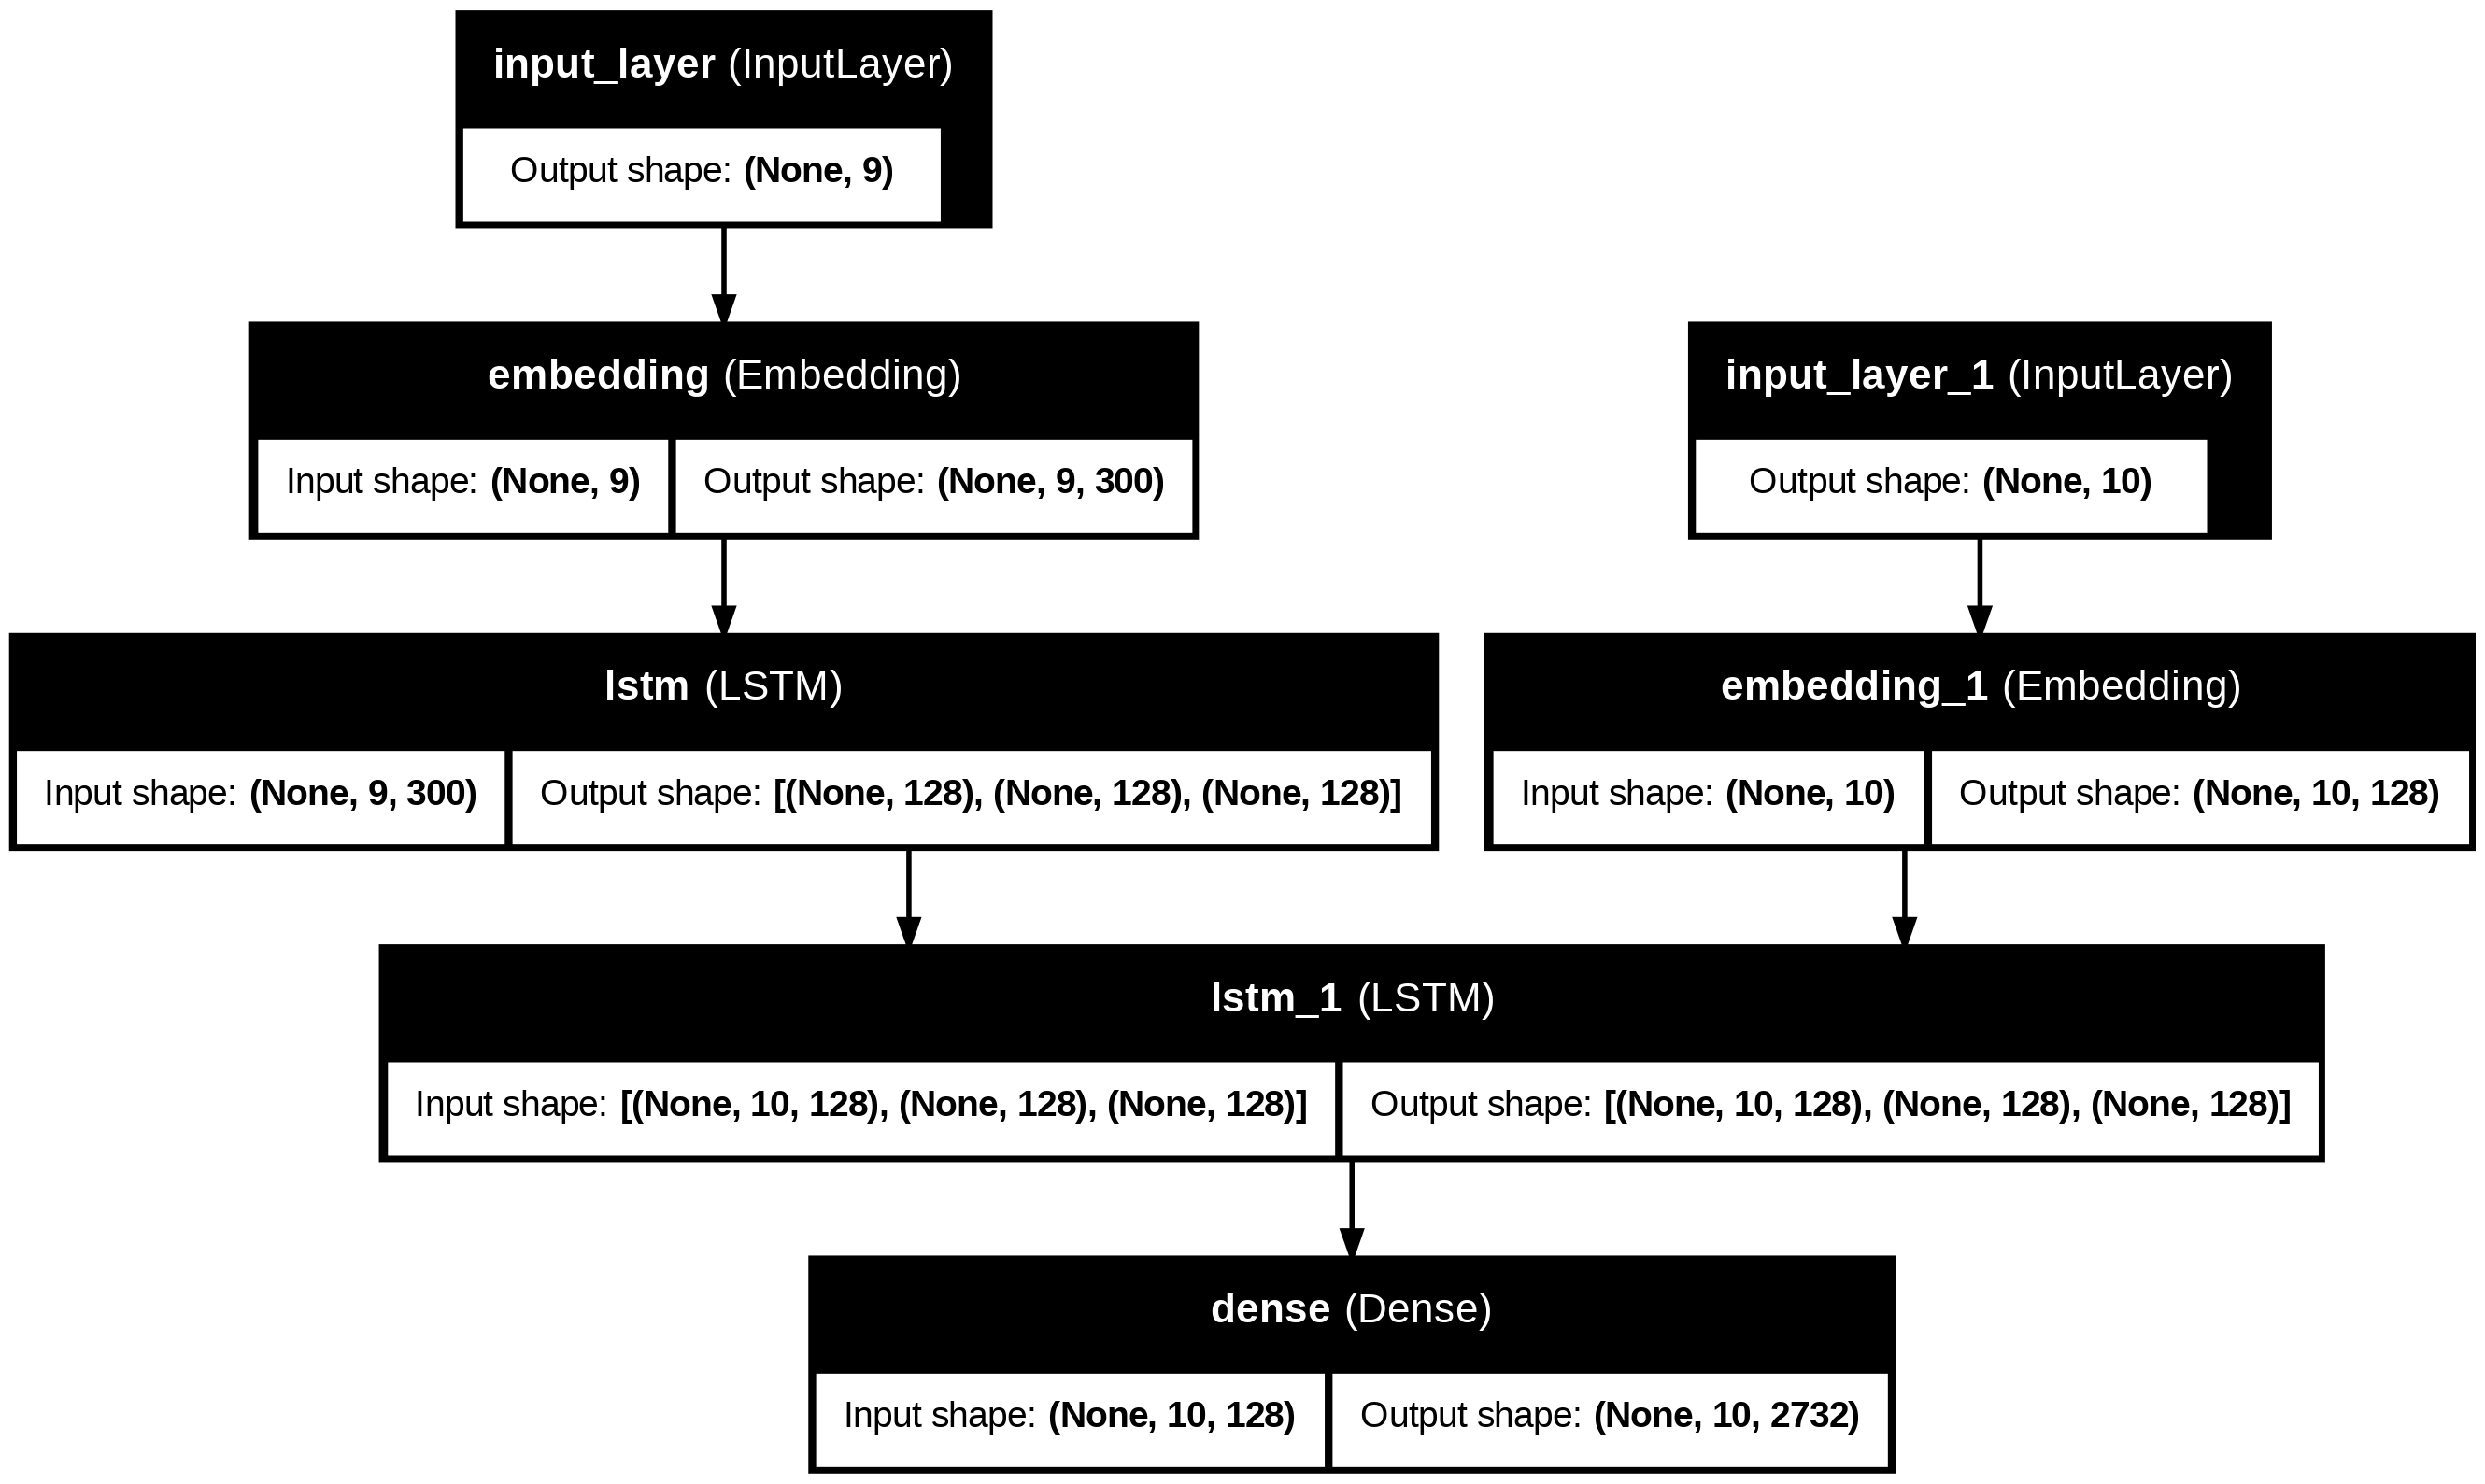

In [21]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

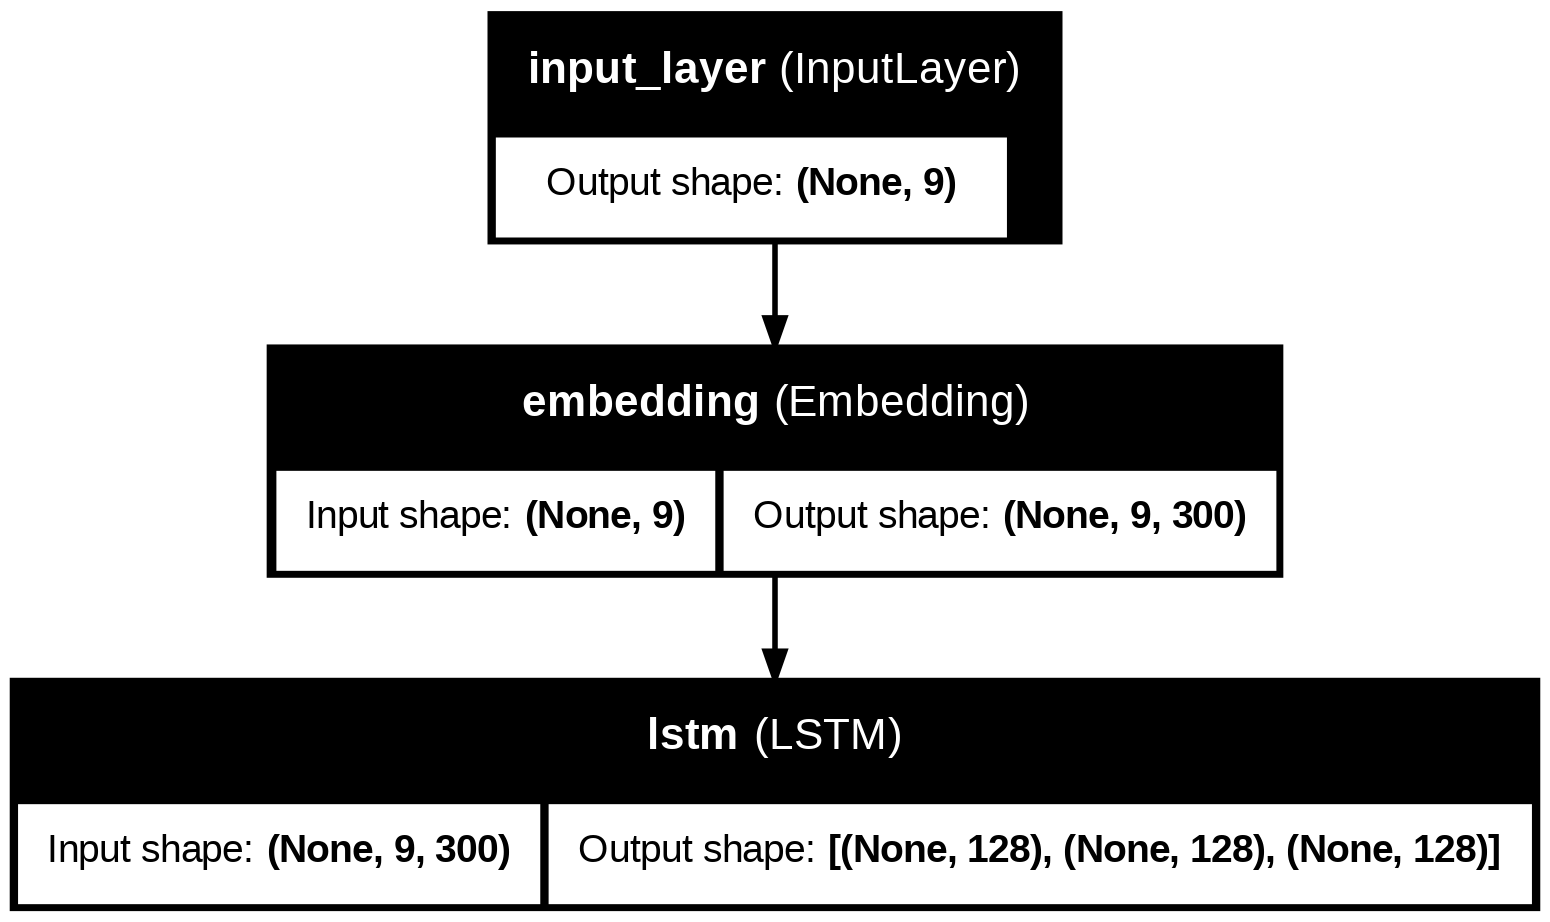

In [22]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

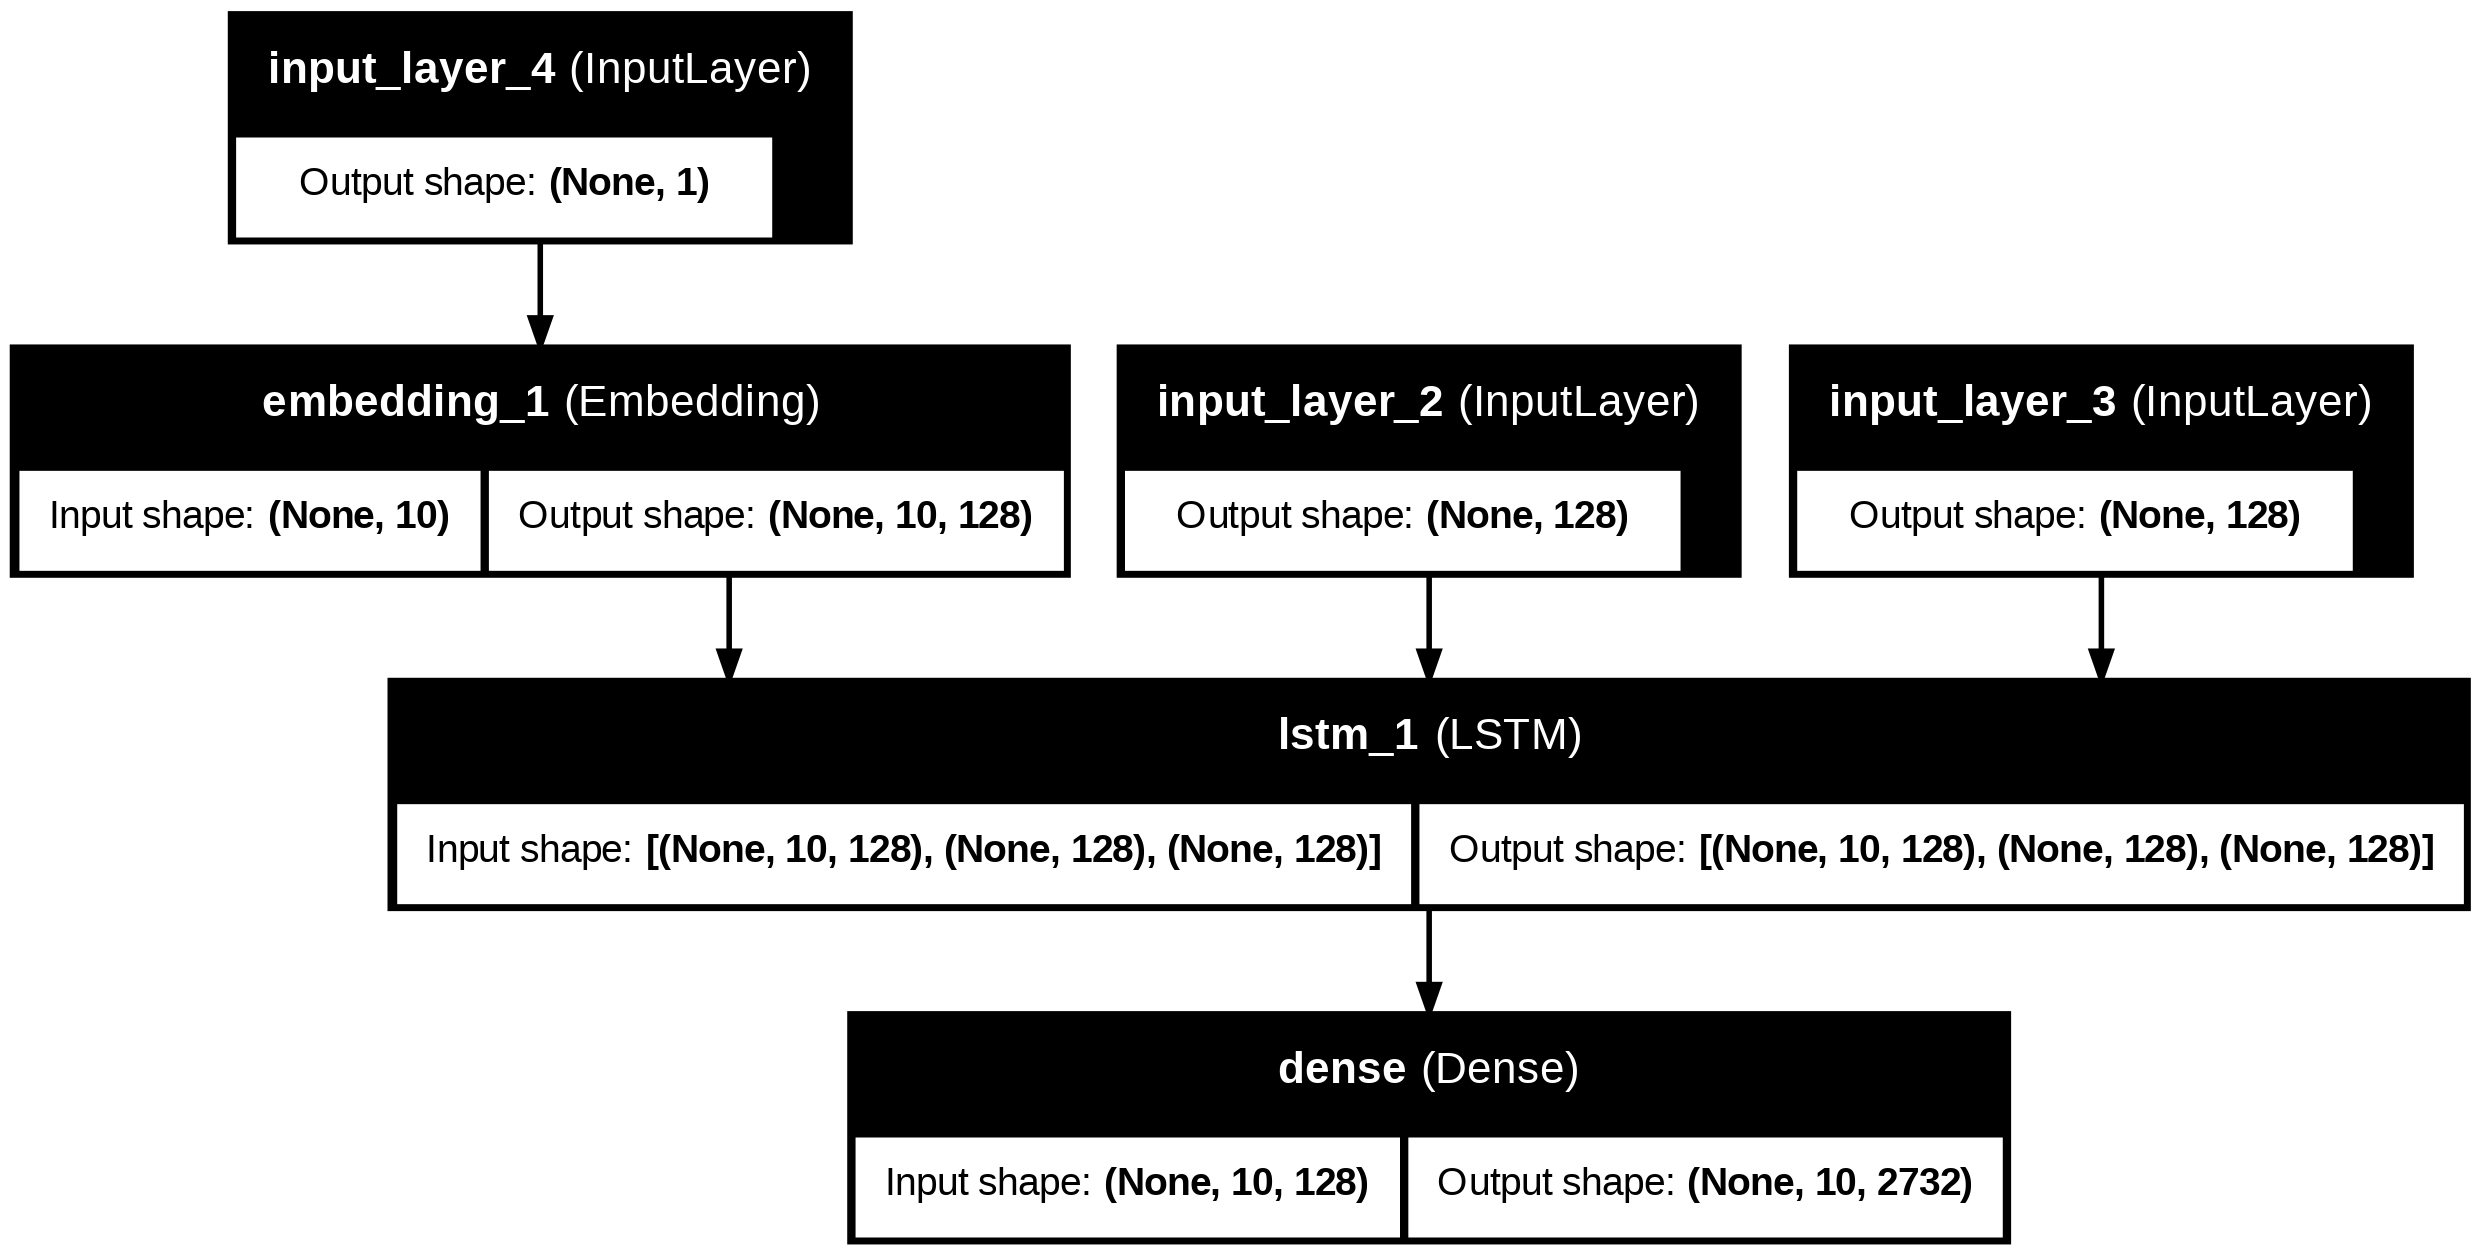

In [23]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
# Definición de callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=0
)


# Entrenamiento con callbacks
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.4392 - loss: 4.0926 - val_accuracy: 0.5689 - val_loss: 2.6284 - learning_rate: 0.0010
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5593 - loss: 2.5353 - val_accuracy: 0.5977 - val_loss: 2.4362 - learning_rate: 0.0010
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5968 - loss: 2.3318 - val_accuracy: 0.6158 - val_loss: 2.3388 - learning_rate: 0.0010
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6137 - loss: 2.2416 - val_accuracy: 0.6245 - val_loss: 2.2677 - learning_rate: 0.0010
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6351 - loss: 2.0961 - val_accuracy: 0.6371 - val_loss: 2.2058 - learning_rate: 0.0010
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6434 - loss: 2.0706 - val_accuracy: 0.6452 - val_loss: 2.1512 - learning_rate: 0.0010
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6528 - 

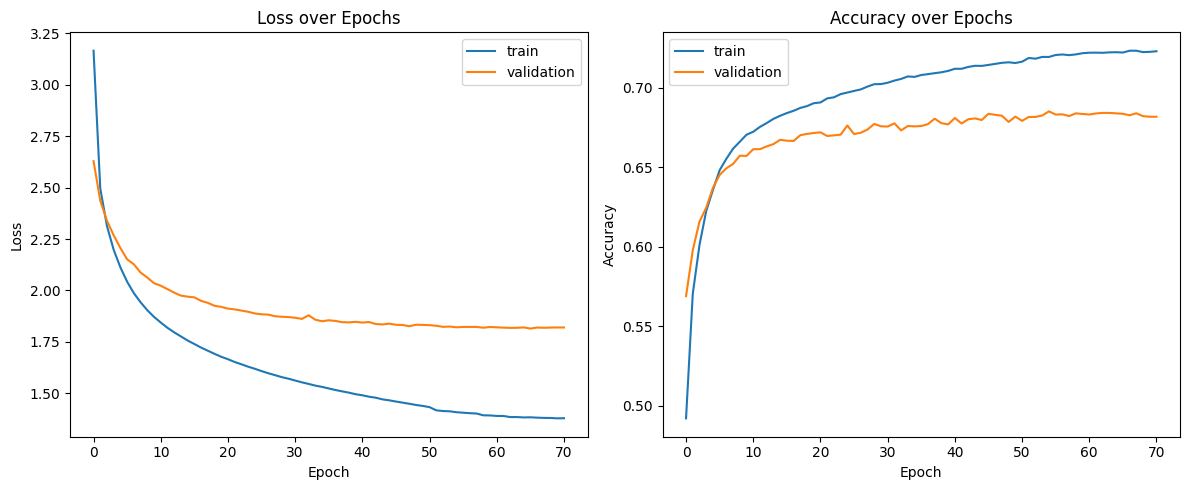

In [25]:
# Gráficamos
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Loss
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_title('Loss over Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'validation'], loc='upper right')

# Accuracy
axs[1].plot(hist.history['accuracy'])
axs[1].plot(hist.history['val_accuracy'])
axs[1].set_title('Accuracy over Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'validation'], loc='upper left')

plt.tight_layout()
plt.show()

El entrenamiento del modelo se detuvo en la época 71 debido a la activación del early stopping, lo que indica que no hubo mejoras significativas en la validación después de ese punto. Durante el proceso, la precisión en el conjunto de entrenamiento alcanzó alrededor del 72%, mientras que la precisión en validación se mantuvo estable cerca del 68%. La pérdida en validación se mantuvo alrededor de 1.8, lo que sugiere que el modelo dejó de mejorar y se estancó. La diferencia entre la precisión en entrenamiento y validación, aunque no muy grande, podría indicar un leve sobreajuste.

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [26]:
# Lista de frases para probar
inputs = [
    "Hi!",
    "How are you?",
    "Where are you from?",
    "What can you do?",
    "Can you help me?",
    "What’s the time?",
    "Are you a BOT?",
    "Bye! Thanks for your time",
    "Have a nice day"
]

In [27]:
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

def predict_answer(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [28]:
# Respuesta
for sentence in inputs:
    integer_seq_test = input_tokenizer.texts_to_sequences([sentence])[0]
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    response = predict_answer(encoder_sequence_test)
    print(f"Input: {sentence}")
    print(f"Response:  {response}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Input: Hi!
Response:  hello how are you

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Input: How are you?
Response:  i am fine

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Input: Where are you from?
Response:  i am a teacher i am a vegan

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

En este notebook se siguió como ejemplo base el notebook trabajado en clases para el preprocesamiento de datos, la tokenización, la definición del modelo y el entrenamiento. Se realizaron varios cambios, como la incorporación de early stopping para evitar el sobreajuste y un scheduler para ajustar la tasa de aprendizaje. Además, se utilizó el optimizador rmsprop. Se probaron distintos hiperparámetros, pero los resultados no mostraron mejoras significativas, por lo que se eliminaron esas pruebas para mantener el código limpio y claro.

Durante el entrenamiento, el modelo alcanzó una precisión moderada, con una pérdida que se estabilizó pero no mejoró sustancialmente en las últimas épocas, lo que indica que el aprendizaje se estancó. En las pruebas con inputs de ejemplo, el modelo generó respuestas coherentes en estructura pero bastante genéricas y repetitivas, y en la mayoría de los casos las respuestas no fueron adecuadas.

Como próximos pasos puede considerarse probar modelos con mayor capacidad, como redes recurrentes más profundas o mecanismos de atención, así como entrenar con embeddings ajustables. También sería útil aumentar la variedad y cantidad del dataset, y evaluar técnicas de regularización o preentrenamiento.